Checking if our halfmass radii seem reasonable by overplotting them on a image

In [2]:
import pynbody
import numpy as np 
import pynbody.plot.sph as sph
import matplotlib.pyplot as plt

import glob

import sys 
sys.path.insert(0, '/home/jw1624/H1-merian/util/')
from util import util

In [3]:
def halfMassRadius_bisect(sim, outerR, acc, maxiter=100000):
    innerLim = 0.0
    outerLim = outerR

    pRadii = np.array(sim.s['r'].in_units('kpc'))
    pMass = np.array(sim.s['mass'])
    mTot = sum(pMass)

    r = outerR/2
    hm = sum(pMass[pRadii < r])
    n=0
    while(hm < (0.5-acc)*mTot or hm > (0.5+acc)*mTot):
        if hm > 0.5*mTot: # too big, decrease r
            outerLim = r
            r = innerLim + (outerLim-innerLim)/2
        elif hm < 0.5*mTot: # too small increase r
            innerLim = r
            r = innerLim + (outerLim-innerLim)/2
        hm = sum(pMass[pRadii < r])

        n += 1
        if n>maxiter:
            return -1
            break

    return r

## Images

In [4]:
# image function
def makeStarImage(hID, ts=0, width=20, sidm=0):
    baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
    galDir = baseDir+ '/r' + str(hID)+'.romulus25.3072g1HsbBH'

    timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
    timesteps.sort(reverse=True)

    f = glob.glob(timesteps[ts]+'/r*.00'+timesteps[ts][-4:])[0]
    
    v_disp = -1

    fig, ax = plt.subplots(1,1, figsize=(8,8), facecolor='w')

    s = pynbody.load(f)
    s.physical_units()

    # center
    hCDM = -1
    try:
        hCDM = s.halos(write_fpos=False)[1]
    except:
        # center manually if missing halo; taken from pynbody source code
        print('HNF')
        i = s['phi'].argmin()
        cen_pot = s['pos'][i].copy()
        s['pos'] -= cen_pot
        print('centered manually')
    else:
        hCDM = s.halos(write_fpos=False)[1]
        cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
        s['pos'] -= cen_pot

        pynbody.analysis.angmom.faceon(hCDM)

    im = pynbody.plot.stars.render(s, width=str(width)+' kpc', plot=False, ret_im=True)
    print('img rendered')
    
    pxlwid = len(im[0])
    pxlKpcRatio = pxlwid/width
    
    tag = 'CDM'
    if sidm: tag = 'SIDM'
    plt.title('r'+str(hID) + ' '+tag, fontsize=20, fontfamily='serif')

    # find radius and plot as circle
    hmr = halfMassRadius_bisect(s, width, 0.01)
    print(hmr)
    
    circle = plt.Circle((pxlwid/2,pxlwid/2), hmr*pxlKpcRatio, edgecolor='g', linewidth=3, fill=False)
    
    ax.imshow(im)
    ax.add_patch(circle)
    
    plt.tight_layout()

In [5]:
currentGals = util.getGalaxies()[0]

/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/halo/ahf.py:673: UserWarning: Did not find a suitable AHF halo catalogue file -- will attempt to run AHF to generate one or fallback to other halo catalogues
  warnings.warn("Did not find a suitable AHF halo catalogue file -- will attempt to run AHF to generate one or fallback to other halo catalogues")


HNF


/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/plot/stars.py:72: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(image*pc2_to_sqarcsec)
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/array.py:434: RuntimeWarning: invalid value encountered in subtract
  r = add_op(self, x)
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/plot/stars.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  X = (arr - mini) / (maxi - mini)


-1


/home/jw1624/miniconda3/lib/python3.9/site-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


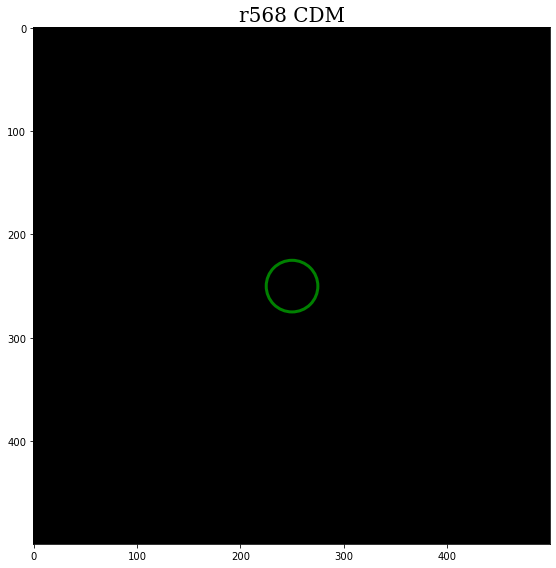

In [28]:
makeStarImage(currentGals[8], 1)

## Can we use a scatter plot?

In [20]:
def makeScatterImage(hID, ts=0, width=20, sidm=0):
    baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
    galDir = baseDir+ '/r' + str(hID)+'.romulus25.3072g1HsbBH'

    timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
    timesteps.sort(reverse=True)

    f = glob.glob(timesteps[ts]+'/r*.00'+timesteps[ts][-4:])[0]

    s = pynbody.load(f)
    s.physical_units()

    # center
    hCDM = -1
    try:
        hCDM = s.halos(write_fpos=False)[1]
    except:
        # center manually if missing halo; taken from pynbody source code
        print('HNF')
        mtot = s.s['mass'].sum()
        cen = np.sum(s.s['mass'] * s.s['pos'].transpose(), axis=1) / mtot
        cen.units = s.s['pos'].units 
        s['pos'] -= cen
        print('centered manually: ', cen)
    else:
        hCDM = s.halos(write_fpos=False)[1]
        cen = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
        s['pos'] -= cen

        pynbody.analysis.angmom.faceon(hCDM)
     
    hmr = halfMassRadius_bisect(s, width, 0.01)
    
    # do image
    fig, axs = plt.subplots(1,3, figsize=(18,6), facecolor='w')

    c1 = plt.Circle((0,0), hmr, edgecolor='g', linewidth=3, fill=False)
    c2 = plt.Circle((0,0), hmr, edgecolor='g', linewidth=3, fill=False)
    c3 = plt.Circle((0,0), hmr, edgecolor='g', linewidth=3, fill=False)

    axs[0].scatter(s.s['pos'][:,0], s.s['pos'][:,1], s=1)
    axs[1].scatter(s.s['pos'][:,0], s.s['pos'][:,2], s=1)
    axs[2].scatter(s.s['pos'][:,1], s.s['pos'][:,2], s=1)

    axs[0].add_patch(c1)
    axs[1].add_patch(c2)
    axs[2].add_patch(c3)

    axs[1].set_title('r'+str(hID)+': '+str(timesteps[ts][-4:]), fontsize=20, fontfamily='serif')
    axs[2].set_title(')

    lim = 35
    for ax in axs:
        ax.set_xlim([-lim,lim])
        ax.set_ylim([-lim,lim])

    plt.tight_layout()
    

HNF
centered manually:  [  630.15306391  1481.1851748  -2651.02930576]


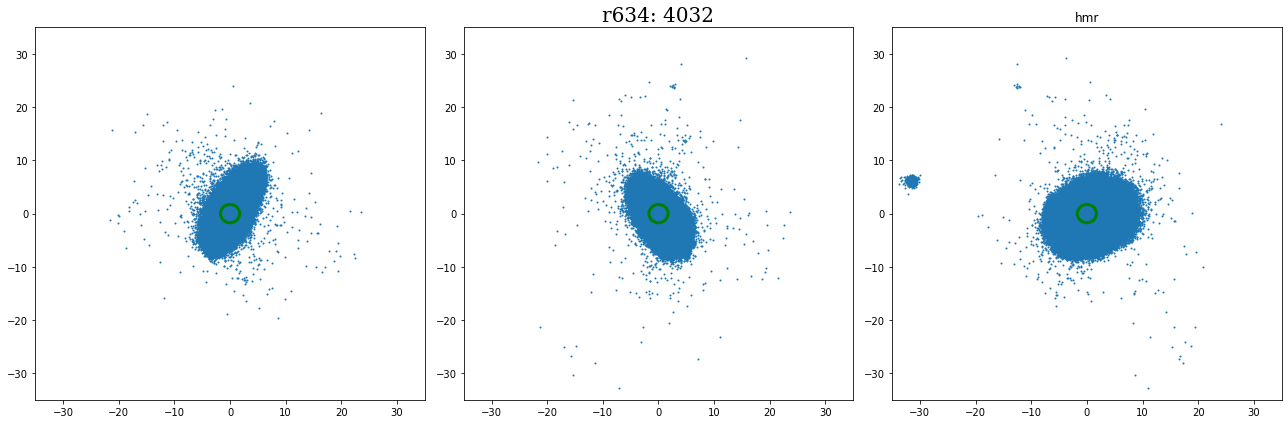

In [21]:
makeScatterImage(currentGals[15], 1)